In [1]:
import os
from pathlib import Path
import random
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from tqdm.auto import tqdm

import torchvision.transforms as T
import torchvision
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

In [ ]:

COMP_PATH = Path("../input/deep-learning-for-computer-vision-and-nlp-2026-01")
FOLDS_PATH = Path("../input/petfinder-train-folds/train_folds.csv")  

TRAIN_CSV = COMP_PATH / "train.csv"
TEST_CSV  = COMP_PATH / "test.csv"
IMG_DIR_TRAIN   = COMP_PATH / "images/images/train"
IMG_DIR_TEST    = COMP_PATH / "images/images/test"
IMG_DIR = COMP_PATH / "images/images"

print("train exists:", TRAIN_CSV.exists())
print("test exists :", TEST_CSV.exists())
print("images dir  :", IMG_DIR.exists())
print("folds exists:", FOLDS_PATH.exists())

train exists: True
test exists : True
images dir  : True
folds exists: True


In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
folds_df = pd.read_csv(FOLDS_PATH)

print(train_df.shape, test_df.shape, folds_df.shape)
train_df.head()

(6431, 3) (1891, 2) (6431, 3)


,PetID,Description,AdoptionSpeed
0,d3b4f29f8,Mayleen and Flo are two lovely adorable sister...,2
1,e9dc82251,A total of 5 beautiful Tabbys available for ad...,2
2,8111f6d4a,Two-and-a-half month old girl. Very manja and ...,2
3,693a90fda,Neil is a healthy and active ~2-month-old fema...,2
4,9d08c85ef,Gray kitten available for adoption in sungai p...,2


In [4]:
train_df = train_df.merge(folds_df, on=["PetID", "AdoptionSpeed"], how="left")
print("after merge:", train_df.shape)
train_df[["PetID","AdoptionSpeed","fold"]].head()

after merge: (6431, 4)


,PetID,AdoptionSpeed,fold
0,d3b4f29f8,2,3
1,e9dc82251,2,3
2,8111f6d4a,2,2
3,693a90fda,2,4
4,9d08c85ef,2,3


In [5]:
train_imgs = list(IMG_DIR_TRAIN.glob("*"))
print("total image files:", len(train_imgs))
print("sample:", [p.name for p in train_imgs[:10]])

total image files: 28472
sample: ['61d4dc56b-12.jpg', '53923463d-9.jpg', '0173c456c-8.jpg', 'fa7c7d1be-3.jpg', '1a030d758-1.jpg', 'd9f692e74-2.jpg', 'ebc345fe0-4.jpg', '2c24655fe-6.jpg', '94438a5c5-4.jpg', 'c9ff29578-13.jpg']


In [6]:
# Check matching between image files and CSV PetIDs

petids_in_csv = set(train_df["PetID"].astype(str))

sample_files = random.sample(train_imgs, 200)
prefixes = [p.name.split("-", 1)[0] for p in sample_files]

match_rate = sum(pref in petids_in_csv for pref in prefixes) / len(prefixes)

print("Match rate:", match_rate)
print("Example prefixes:", prefixes[:10])

Match rate: 1.0
Example prefixes: ['ab4b4681b', '269192694', '49113adb2', '3816b16b4', '40d7cb083', 'd09a7dda3', '3c6f9a4e7', '881a77dfb', 'c863daf49', '261cbe336']


In [7]:
petid_to_images = defaultdict(list)

for img_path in train_imgs:
    pet_id = img_path.name.split("-", 1)[0]
    petid_to_images[pet_id].append(img_path)

print("Total PetIDs with images:", len(petid_to_images))

Total PetIDs with images: 6431


In [8]:
test_imgs = list(IMG_DIR_TEST.glob("*"))
print("total image files:", len(test_imgs))
print("sample:", [p.name for p in test_imgs[:10]])

total image files: 9448
sample: ['cf8d949f9-2.jpg', '41e824cbe-3.jpg', '687be6419-4.jpg', '081199ea2-12.jpg', '924cc5438-4.jpg', 'b1ed265ef-11.jpg', '9daaa4e8f-1.jpg', '062de1f53-4.jpg', '0ce5d0b5f-3.jpg', 'd4bb8cf0a-4.jpg']


In [9]:
petids_in_csv = set(test_df["PetID"].astype(str))

sample_files = random.sample(test_imgs, 200)
prefixes = [p.name.split("-", 1)[0] for p in sample_files]

match_rate = sum(pref in petids_in_csv for pref in prefixes) / len(prefixes)

print("Match rate:", match_rate)
print("Example prefixes:", prefixes[:10])

Match rate: 0.995
Example prefixes: ['353c89ed3', '89d80665a', '826c26e34', '9951b9762', '41e824cbe', '409ccc60e', '4f5f178e6', 'd596234fc', 'b1ed265ef', '654acdb4b']


In [10]:
# example output
some_pet = list(petid_to_images.keys())[3]
print(some_pet)
print(petid_to_images[some_pet])

fa7c7d1be
[PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-3.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-1.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-2.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-4.jpg')]


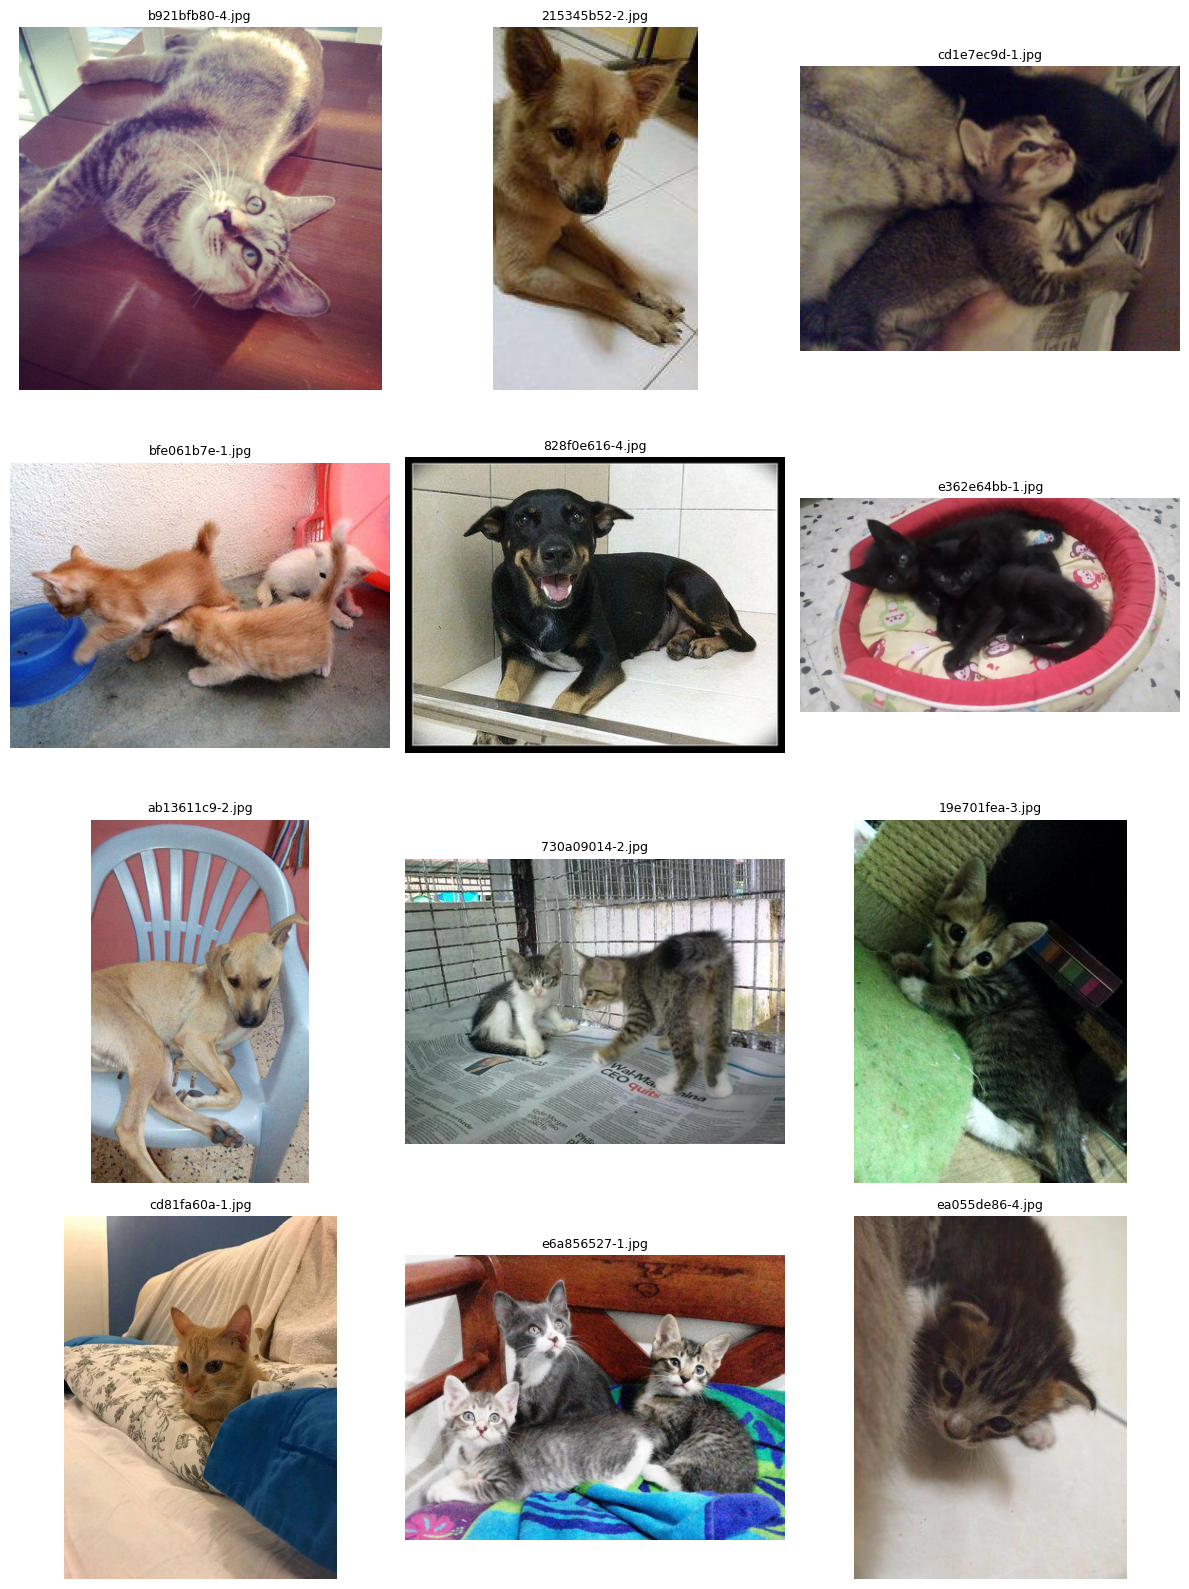

In [11]:
n_rows, n_cols = 4, 3
n = n_rows * n_cols

sample_paths = random.sample(train_imgs, k=n)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16))
axes = axes.flatten()

for ax, p in zip(axes, sample_paths):
    img = Image.open(p).convert("RGB")
    ax.imshow(img)
    ax.set_title(p.name, fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [12]:
class PetDataset(Dataset):
    def __init__(self, df, petid_to_images, transform=None):
        self.transform = transform
        self.samples = []

        df = df.reset_index(drop=True)
        for _, row in df.iterrows():
            pet_id = str(row["PetID"])
            label = row["AdoptionSpeed"] - 1  # 0..3

            paths = petid_to_images.get(pet_id, [])
            for p in paths:
                self.samples.append((p, label, pet_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, pet_id = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, pet_id

In [13]:
IMG_SIZE = 380

weights = EfficientNet_B4_Weights.DEFAULT
mean = weights.transforms().mean
std  = weights.transforms().std

train_tfms = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.70, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
    T.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value="random"),
])

val_tfms = T.Compose([
    T.Resize(436),          # ~ IMG_SIZE / 0.87
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

In [14]:
FOLD=0
df_tr = train_df[train_df["fold"] != FOLD].reset_index(drop=True)
df_va = train_df[train_df["fold"] == FOLD].reset_index(drop=True)

train_ds = PetDataset(df_tr, petid_to_images, transform=train_tfms)
val_ds   = PetDataset(df_va, petid_to_images, transform=val_tfms)

len(train_ds), len(val_ds)

(22797, 5675)

In [15]:
BATCH_SIZE = 16
NUM_WORKERS = 4 
N_SPLITS = 5
EPOCHS = 3
LR = 1e-4     
PIN_MEMORY  = True

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,     
    drop_last=False       
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False
)

print("train batches:", len(train_loader))
print("val batches  :", len(val_loader))

train batches: 1425
val batches  : 355


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # режим навчання (вмикає dropout, batchnorm у train-режимі)

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="train", leave=False)

    for x, y, _ in pbar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()         
        logits = model(x)            
        loss = criterion(logits, y)    

        loss.backward()               
        optimizer.step()               

        bs = x.size(0)
        running_loss += loss.item() * bs
        total += bs

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

        pbar.set_postfix(loss=float(loss.item()))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
@torch.no_grad()
def valid_epoch_with_probs(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    probs_list = []
    petids_list = []
    labels_list = []

    pbar = tqdm(loader, desc="valid", leave=False)

    for x, y, pet_id in pbar:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        running_loss += loss.item() * bs
        total += bs

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
        probs_list.append(probs)

        # pet_id може бути list[str] або tuple[str]
        petids_list.extend(list(pet_id))
        labels_list.extend(y.cpu().numpy().tolist())

        pbar.set_postfix(loss=float(loss.item()))

    val_loss = running_loss / total
    val_acc = correct / total

    probs_all = np.vstack(probs_list)          # (N_images, 4)
    petids_all = np.array(petids_list)         # (N_images,)
    labels_all = np.array(labels_list)         # (N_images,)

   
    df = pd.DataFrame(probs_all, columns=["p0","p1","p2","p3"])
    df["PetID"] = petids_all
    df["label"] = labels_all

    df_pet = df.groupby("PetID", as_index=False).agg({
        "p0":"mean","p1":"mean","p2":"mean","p3":"mean","label":"first"
    })

    val_probs_pet = df_pet[["p0","p1","p2","p3"]].values     # (N_pets, 4)
    val_labels_pet = df_pet["label"].values                  # (N_pets,)

    return val_loss, val_acc, val_probs_pet, val_labels_pet, df_pet[["PetID"]]

In [19]:
def build_model():
    model = torchvision.models.efficientnet_b4(
        weights=EfficientNet_B4_Weights.DEFAULT
    )
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 4)
    return model

In [20]:
def build_optimizer(model):
    return torch.optim.AdamW(
        model.parameters(),
        lr=LR,
        weight_decay=1e-4
    )

In [21]:
def build_criterion():
    return nn.CrossEntropyLoss()

In [ ]:
oof_parts = []  

for FOLD in range(N_SPLITS):
    print(f"\n===== FOLD {FOLD} =====")

    # 1) split
    df_tr = train_df[train_df["fold"] != FOLD].reset_index(drop=True)
    df_va = train_df[train_df["fold"] == FOLD].reset_index(drop=True)

    # 2) datasets/loaders
    train_ds = PetDataset(df_tr, petid_to_images, transform=train_tfms)
    val_ds   = PetDataset(df_va, petid_to_images, transform=val_tfms)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

    # 3) model/opt
    model = build_model().to(device)          
    optimizer = build_optimizer(model)     
    criterion = build_criterion()            

    best_qwk = -1e9
    best_oof_fold = None

    # 4) epochs loop
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc, val_probs_pet, val_labels_pet, val_petids = valid_epoch_with_probs(
            model, val_loader, criterion, device
        )

        val_pred = val_probs_pet.argmax(axis=1)
        val_qwk = cohen_kappa_score(val_labels_pet + 1, val_pred + 1, weights="quadratic")

        print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | QWK={val_qwk:.4f}")

      
        if val_qwk > best_qwk:
            best_qwk = val_qwk
            pet_ids = val_petids["PetID"].values
            best_oof_fold = pd.DataFrame({
                "PetID": pet_ids,
                "pred_0": val_probs_pet[:, 0],
                "pred_1": val_probs_pet[:, 1],
                "pred_2": val_probs_pet[:, 2],
                "pred_3": val_probs_pet[:, 3],
                "fold": FOLD
            })

 
    assert best_oof_fold is not None, f"OOF for fold {FOLD} is None"
    oof_parts.append(best_oof_fold)
    print(f"FOLD {FOLD} best_QWK={best_qwk:.4f}")


df_oof_all = pd.concat(oof_parts, ignore_index=True)
df_oof_all.to_csv("/kaggle/working/cnn_oof.csv", index=False)
print("saved:", "/kaggle/working/cnn_oof.csv", df_oof_all.shape)


===== FOLD 0 =====
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 179MB/s] 


train:   0%|          | 0/1425 [00:00<?, ?it/s]

valid:   0%|          | 0/355 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2395 | val_loss=1.2079 | QWK=0.5030


train:   0%|          | 0/1425 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/355 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1358 | val_loss=1.2197 | QWK=0.4898


train:   0%|          | 0/1425 [00:00<?, ?it/s]

valid:   0%|          | 0/355 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0496 | val_loss=1.2605 | QWK=0.4629
FOLD 0 best_QWK=0.5030

===== FOLD 1 =====


train:   0%|          | 0/1435 [00:00<?, ?it/s]

valid:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2333 | val_loss=1.2171 | QWK=0.5141


train:   0%|          | 0/1435 [00:00<?, ?it/s]

valid:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1305 | val_loss=1.2180 | QWK=0.5264


train:   0%|          | 0/1435 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0435 | val_loss=1.2485 | QWK=0.5069
FOLD 1 best_QWK=0.5264

===== FOLD 2 =====


train:   0%|          | 0/1424 [00:00<?, ?it/s]

valid:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2425 | val_loss=1.1917 | QWK=0.5145


train:   0%|          | 0/1424 [00:00<?, ?it/s]

valid:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1342 | val_loss=1.2075 | QWK=0.5262


train:   0%|          | 0/1424 [00:00<?, ?it/s]

valid:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0370 | val_loss=1.2466 | QWK=0.5114
FOLD 2 best_QWK=0.5262

===== FOLD 3 =====


train:   0%|          | 0/1406 [00:00<?, ?it/s]

valid:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2444 | val_loss=1.2071 | QWK=0.5021


train:   0%|          | 0/1406 [00:00<?, ?it/s]

valid:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1397 | val_loss=1.2051 | QWK=0.5132


train:   0%|          | 0/1406 [00:00<?, ?it/s]

valid:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0511 | val_loss=1.2347 | QWK=0.4992
FOLD 3 best_QWK=0.5132

===== FOLD 4 =====


train:   0%|          | 0/1430 [00:00<?, ?it/s]

valid:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2375 | val_loss=1.2202 | QWK=0.5264


train:   0%|          | 0/1430 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1276 | val_loss=1.2429 | QWK=0.5365


train:   0%|          | 0/1430 [00:00<?, ?it/s]

valid:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0362 | val_loss=1.2727 | QWK=0.5143
FOLD 4 best_QWK=0.5365
saved: /kaggle/working/cnn_oof.csv (6431, 6)


In [23]:
class PetTestImageDataset(Dataset):
    def __init__(self, df, petid_to_images_test, transform=None, img_size=224):
        self.transform = transform
        self.samples = []
        self.img_size = img_size

        df = df.reset_index(drop=True)
        for _, row in df.iterrows():
            pet_id = str(row["PetID"])
            paths = petid_to_images_test.get(pet_id, [])

            if len(paths) == 0:
                # важливо: щоб PetID не зник з тесту
                self.samples.append((None, pet_id))
            else:
                for p in paths:
                    self.samples.append((p, pet_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, pet_id = self.samples[idx]

        if img_path is None:
            # чорна заглушка
            image = Image.new("RGB", (self.img_size, self.img_size), (0, 0, 0))
        else:
            image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, pet_id

In [ ]:
petid_to_images_test = defaultdict(list)
for img_path in test_imgs: 
    pet_id = img_path.name.split("-", 1)[0]
    petid_to_images_test[pet_id].append(img_path)

print("Total test PetIDs with images:", len(petid_to_images_test))

Total test PetIDs with images: 1899


In [25]:
test_ds = PetTestImageDataset(
    df=test_df,
    petid_to_images_test=petid_to_images_test,
    transform=val_tfms,
    img_size=IMG_SIZE
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False
)

print("test samples:", len(test_ds))
print("test batches :", len(test_loader))

test samples: 9363
test batches : 586


In [26]:
@torch.no_grad()
def predict_test_with_probs(model, loader, device):
    model.eval()

    probs_list = []
    petids_list = []

    pbar = tqdm(loader, desc="test", leave=False)

    for x, pet_id in pbar:
        x = x.to(device)

        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()  # (bs, 4)

        probs_list.append(probs)
        petids_list.extend(list(pet_id))

    probs_all  = np.vstack(probs_list)          # (N_images, 4)
    petids_all = np.array(petids_list)          # (N_images,)

    df_img = pd.DataFrame(probs_all, columns=["pred_0","pred_1","pred_2","pred_3"])
    df_img["PetID"] = petids_all

    # mean по PetID => (N_pets, 4)
    df_pet = df_img.groupby("PetID", as_index=False)[["pred_0","pred_1","pred_2","pred_3"]].mean()

    # гарантуємо, що всі PetID з test_df присутні
    df_pet = test_df[["PetID"]].merge(df_pet, on="PetID", how="left")

    # якщо раптом лишились NaN (не повинно бути, але безпечно)
    df_pet[["pred_0","pred_1","pred_2","pred_3"]] = df_pet[["pred_0","pred_1","pred_2","pred_3"]].fillna(0.25)

    return df_pet

In [27]:
test_ds = PetTestImageDataset(
    df=test_df,
    petid_to_images_test=petid_to_images_test,
    transform=val_tfms,
    img_size=IMG_SIZE
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False
)

oof_parts = []
test_parts = []

for FOLD in range(N_SPLITS):
    print(f"\n===== FOLD {FOLD} =====")

    df_tr = train_df[train_df["fold"] != FOLD].reset_index(drop=True)
    df_va = train_df[train_df["fold"] == FOLD].reset_index(drop=True)

    train_ds = PetDataset(df_tr, petid_to_images, transform=train_tfms)
    val_ds   = PetDataset(df_va, petid_to_images, transform=val_tfms)

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=PIN_MEMORY, drop_last=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=PIN_MEMORY, drop_last=False
    )

    model = build_model().to(device)
    optimizer = build_optimizer(model)
    criterion = build_criterion()

    best_qwk = -1e9
    best_oof_fold = None

    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc, val_probs_pet, val_labels_pet, val_petids = valid_epoch_with_probs(
            model, val_loader, criterion, device
        )

        val_pred = val_probs_pet.argmax(axis=1)
        val_qwk = cohen_kappa_score(val_labels_pet + 1, val_pred + 1, weights="quadratic")

        print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | QWK={val_qwk:.4f}")

        if val_qwk > best_qwk:
            best_qwk = val_qwk
            best_oof_fold = pd.DataFrame({
                "PetID": val_petids["PetID"].values,
                "pred_0": val_probs_pet[:, 0],
                "pred_1": val_probs_pet[:, 1],
                "pred_2": val_probs_pet[:, 2],
                "pred_3": val_probs_pet[:, 3],
                "fold": FOLD
            })

    oof_parts.append(best_oof_fold)
    print(f"FOLD {FOLD} BEST QWK = {best_qwk:.4f}")

    df_test_fold = predict_test_with_probs(model, test_loader, device)
    df_test_fold["fold"] = FOLD
    test_parts.append(df_test_fold)

    # --- PARTIAL SAVE AFTER EACH FOLD (SAFETY) ---
    pd.concat(oof_parts, ignore_index=True).to_csv("/kaggle/working/cnn_oof_train_partial.csv", index=False)
    pd.concat(test_parts, ignore_index=True).to_csv("/kaggle/working/cnn_test_parts_partial.csv", index=False)
    print("partial saved after fold", FOLD)

# --- FINAL SAVE ---
df_oof_all = pd.concat(oof_parts, ignore_index=True)
df_oof_all.to_csv("/kaggle/working/cnn_oof_train.csv", index=False)
print("saved:", "/kaggle/working/cnn_oof_train.csv", df_oof_all.shape)

df_test_all = pd.concat(test_parts, ignore_index=True)
df_test_all.to_csv("/kaggle/working/cnn_test_parts.csv", index=False)
print("saved:", "/kaggle/working/cnn_test_parts.csv", df_test_all.shape)

df_test_mean = df_test_all.groupby("PetID", as_index=False)[["pred_0","pred_1","pred_2","pred_3"]].mean()
df_test_mean.to_csv("/kaggle/working/cnn_test.csv", index=False)
print("saved:", "/kaggle/working/cnn_test.csv", df_test_mean.shape())


===== FOLD 0 =====


train:   0%|          | 0/1425 [00:00<?, ?it/s]

valid:   0%|          | 0/355 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2401 | val_loss=1.2106 | QWK=0.5032


train:   0%|          | 0/1425 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/355 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1298 | val_loss=1.2270 | QWK=0.4677


train:   0%|          | 0/1425 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/355 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0359 | val_loss=1.2571 | QWK=0.4687
FOLD 0 BEST QWK = 0.5032


test:   0%|          | 0/586 [00:00<?, ?it/s]

partial saved after fold 0

===== FOLD 1 =====


train:   0%|          | 0/1435 [00:00<?, ?it/s]

valid:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2441 | val_loss=1.2155 | QWK=0.5116


train:   0%|          | 0/1435 [00:00<?, ?it/s]

valid:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1347 | val_loss=1.2110 | QWK=0.5286


train:   0%|          | 0/1435 [00:00<?, ?it/s]

valid:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0393 | val_loss=1.2497 | QWK=0.5140
FOLD 1 BEST QWK = 0.5286


test:   0%|          | 0/586 [00:00<?, ?it/s]

partial saved after fold 1

===== FOLD 2 =====


train:   0%|          | 0/1424 [00:00<?, ?it/s]

valid:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2428 | val_loss=1.1934 | QWK=0.5254


train:   0%|          | 0/1424 [00:00<?, ?it/s]

valid:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1405 | val_loss=1.1996 | QWK=0.5322


train:   0%|          | 0/1424 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9b3298e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0492 | val_loss=1.2719 | QWK=0.5213
FOLD 2 BEST QWK = 0.5322


test:   0%|          | 0/586 [00:00<?, ?it/s]

partial saved after fold 2

===== FOLD 3 =====


train:   0%|          | 0/1406 [00:00<?, ?it/s]

valid:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2420 | val_loss=1.2164 | QWK=0.4972


train:   0%|          | 0/1406 [00:00<?, ?it/s]

valid:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1357 | val_loss=1.1974 | QWK=0.4849


train:   0%|          | 0/1406 [00:00<?, ?it/s]

valid:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0411 | val_loss=1.2302 | QWK=0.4926
FOLD 3 BEST QWK = 0.4972


test:   0%|          | 0/586 [00:00<?, ?it/s]

partial saved after fold 3

===== FOLD 4 =====


train:   0%|          | 0/1430 [00:00<?, ?it/s]

valid:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1/3 | train_loss=1.2379 | val_loss=1.2385 | QWK=0.5046


train:   0%|          | 0/1430 [00:00<?, ?it/s]

valid:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2/3 | train_loss=1.1330 | val_loss=1.2444 | QWK=0.5016


train:   0%|          | 0/1430 [00:00<?, ?it/s]

valid:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3/3 | train_loss=1.0449 | val_loss=1.2849 | QWK=0.5241
FOLD 4 BEST QWK = 0.5241


test:   0%|          | 0/586 [00:00<?, ?it/s]

partial saved after fold 4
saved: /kaggle/working/cnn_oof_train.csv (6431, 6)
saved: /kaggle/working/cnn_test_parts.csv (9455, 6)


TypeError: 'tuple' object is not callable

In [ ]:
# ---------- OOF ----------
df_oof_all = pd.concat(oof_parts, ignore_index=True)
df_oof_all.to_csv("cnn_oof.csv", index=False)

# ---------- TEST ----------
df_test_all = pd.concat(test_parts, ignore_index=True)

df_test_final = (
    df_test_all
    .groupby("PetID", as_index=False)[["pred_0","pred_1","pred_2","pred_3"]]
    .mean()
)

df_test_final.to_csv("cnn_test.csv", index=False)